# Grouping audio into Sound Cells

In [1]:
%cd /Users/bastus/Desktop/Forschungsprojekt/genimpro

/Users/bastus/Desktop/Forschungsprojekt/genimpro


In [3]:
%run importwrapper.py
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def plotGroups(audio,groups,hopSize=1024):
    
    for i in xrange(0, len(groups), 8):
        plt.figure(figsize=(16, 10))
        
        subgroups = groups[i:i+8]
        start = subgroups[0][0]
        end = subgroups[-1][1]
        
    
        plt.plot(audio[start:end],'0.5',label="Audio Waveform",linewidth=0.7)
            
        for j,group in enumerate(subgroups):
            plt.axvspan(group[0]-start,group[1]-start, color='g', alpha=0.3)
            plt.axvline(x=group[0]-start,linewidth=0.5,color='r')
            plt.text(group[0]-start+0.05, 0.05,'%i'% (i+j+1),bbox=dict(boxstyle='round', \
                facecolor='r', alpha=0.5),fontsize=14,horizontalalignment='left')
            
        plt.show()
        wavPlayer(audio[start:end],samplerate)

### Prepare test tracks

In [5]:
track = genimpro.recordings.getRecordingDetails(93,printDetails=1)[4][0]

93 (None):
    Marius Werner (snaredrum): 1/f199ef77-778a-4fa5-9326-f377388687a8.aiff
    Felix Bratfisch (snaredrum): 1/25a85c12-3e51-4aec-9e20-e4643d2dc31d.aiff


In [6]:
audio = genimpro.recordings.getAudioForTrack(track)
filename = track[2]

In [7]:
track2 = genimpro.recordings.getRecordingDetails(133,printDetails=1)[4][1]
audio2 = genimpro.recordings.getAudioForTrack(track2)

133 (import/0003 A B-1.aiff):
    Martin Weigert (recorder): 2/6c79816a-01ff-4742-8462-3ebba84b7eb8.aiff
    Caroline Hausen (recorder): 2/b264c1d3-1737-4df1-99c3-b62e27dfcbf7.aiff


### Grouping by adaptive silence regions

In [8]:
def silenceGaps(frames,order=20):
    
    from scipy.signal import argrelmax 

    consecutiveNumbers = [0]
    for i in range(0,len(frames)-2):
        counter = 0
        j = i

        while 1:
            if j < len(frames)-1:
                if frames[j+1]==1:
                    counter+=1
                    j+=1
                else:
                    break
            else:
                break
                
        consecutiveNumbers.append(counter)
    
    featureArray = np.asarray(consecutiveNumbers)
    
    maxima = argrelmax(featureArray, order=order)
    featureMaxima = maxima[0] -1
    
    silenceGaps = []
    
    for maximum in featureMaxima:
        silenceGaps.append([maximum,maximum+consecutiveNumbers[maximum+1]])
    
    return silenceGaps
            

Identify groups by silent gaps below loudness threshold, then choose significat gaps by local maxima in gaps lengths.

In [13]:
from essentia.standard import *

def groupBySilence(audio,hopSize=1024,t_silence=0.04,plot=0,orderDivisor=15,minGapSize=8):
    
    timestamps = len(audio)
    
    loudness = essentia.standard.Loudness()
    energy = Energy()
    
    silenceFrames = []

    for frame in FrameGenerator(audio, frameSize = hopSize*2, hopSize = hopSize):
        if loudness(frame) >= t_silence:
            silenceFrames.append(0)
        else:
            silenceFrames.append(1)

    gaps = silenceGaps(silenceFrames,int(len(audio)/samplerate/orderDivisor))
    
    gapFrames = []
    
    for gap in gaps:
        if (gap[1]-gap[0])>minGapSize:#10
            gapFrames.extend(range(gap[0],gap[1]))
    
    
    audioFrames = range(0,len(audio)/hopSize)
    groupFrames = [x for x in audioFrames if x not in gapFrames]

    
    from numpy import array, diff, where, split
    result= split(groupFrames, where(diff(groupFrames)>2)[0]+1)
    splitGroupFrames =  map(list, result)
    
    groups = []
    
    for group in splitGroupFrames:
        if len(group) > 4:
            groups.append([group[0]*hopSize,((group[-1]+1)*hopSize)])
        
    return groups

###### Example 1: Preprocessed groups of recorder recording

In [11]:
track3 = genimpro.recordings.getRecordingDetails(127,printDetails=1)[4][0]
audio3 = genimpro.recordings.getAudioForTrack(track3,normalize=2)

t_silence = track3[6]
print t_silence

minGapSize = track3[7]
print minGapSize

127 (import/0001 A C-1.aiff):
    Martin Weigert (recorder): 2/664e3329-b099-49ad-a139-c8b791242115.aiff
    Johanna Steinborn (recorder): 2/2ad882dd-932b-4573-8811-96829a37d973.aiff
0.04
12


127 (import/0001 A C-1.aiff):
    Martin Weigert (recorder): 2/664e3329-b099-49ad-a139-c8b791242115.aiff
    Johanna Steinborn (recorder): 2/2ad882dd-932b-4573-8811-96829a37d973.aiff
0.04
12


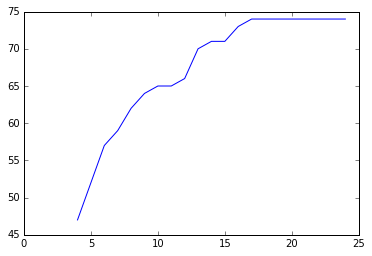

In [19]:
orderDivisors = range(4,25)
numOfGroups = []
for divisor in orderDivisors:
    groups = groupBySilence(audio2,minGapSize=minGapSize,t_silence=t_silence,orderDivisor=divisor)
    numOfGroups.append(len(groups))
    
plt.plot(orderDivisors,numOfGroups)

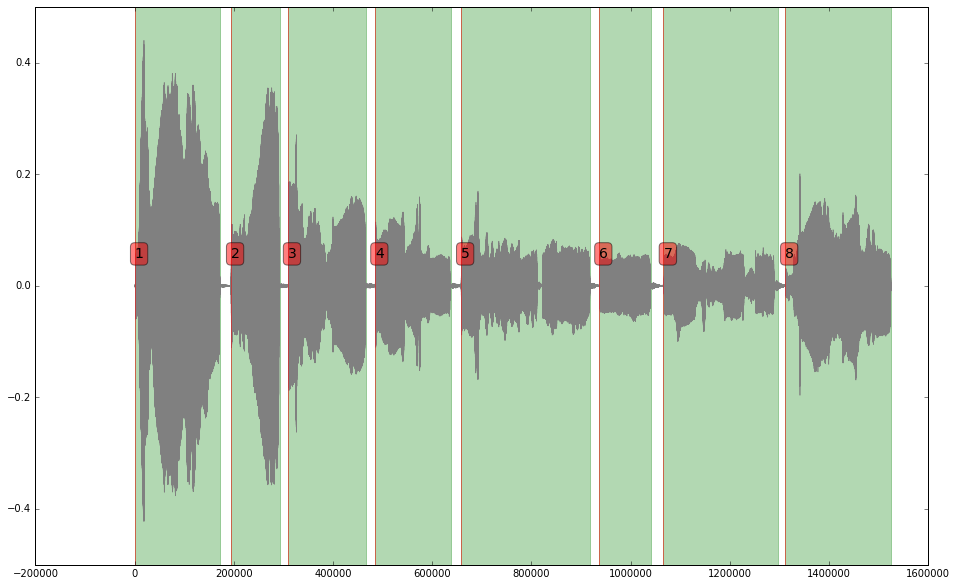

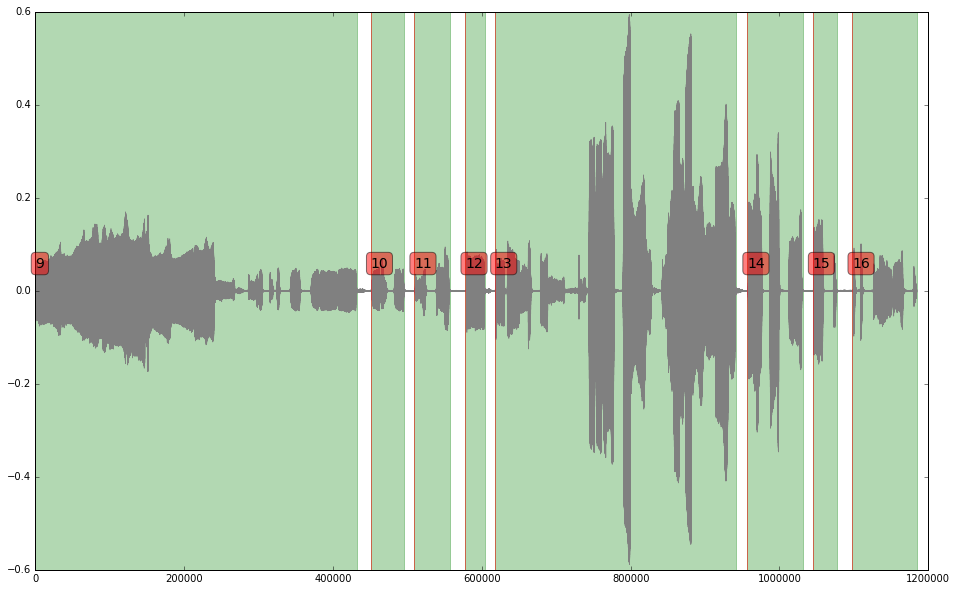

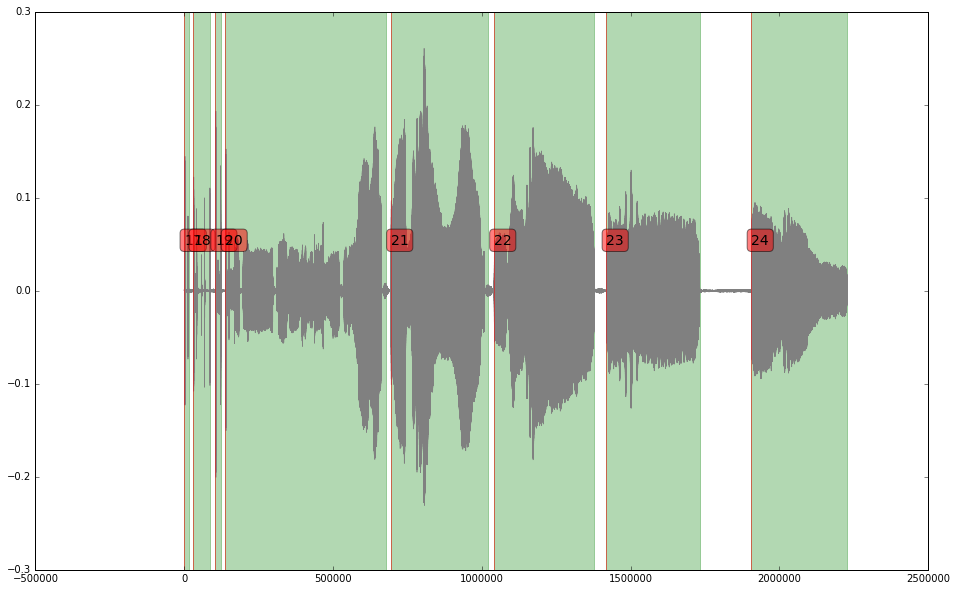

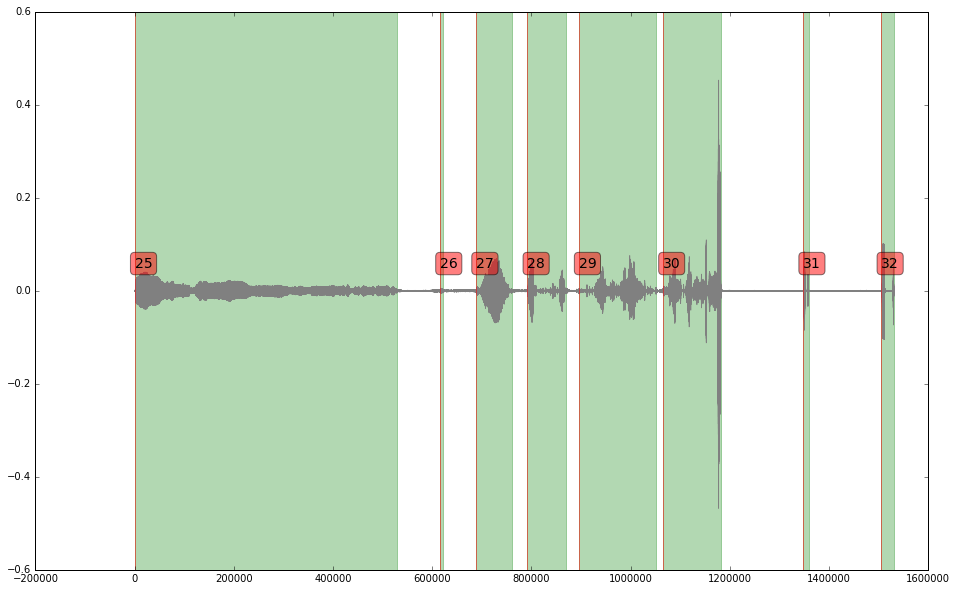

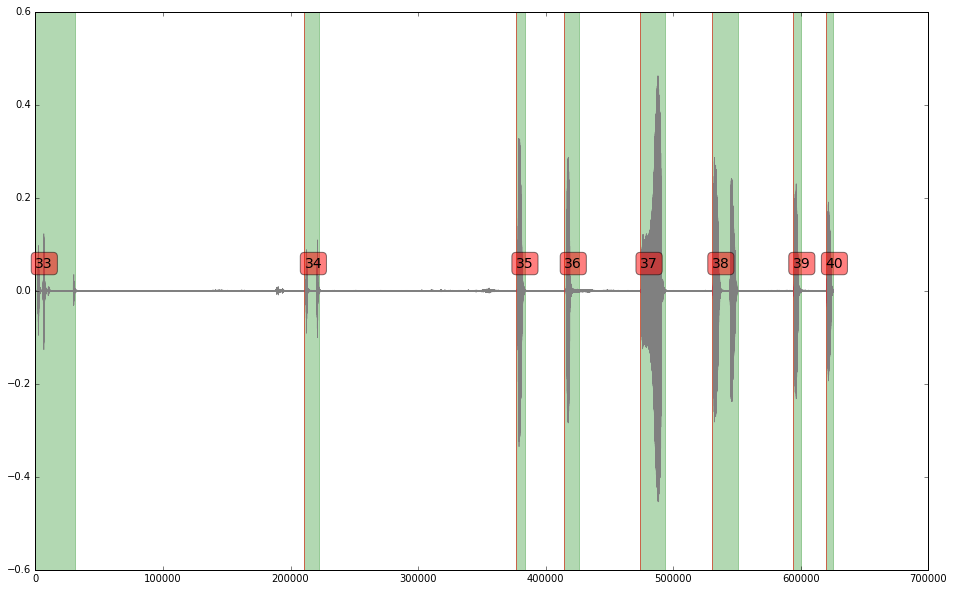

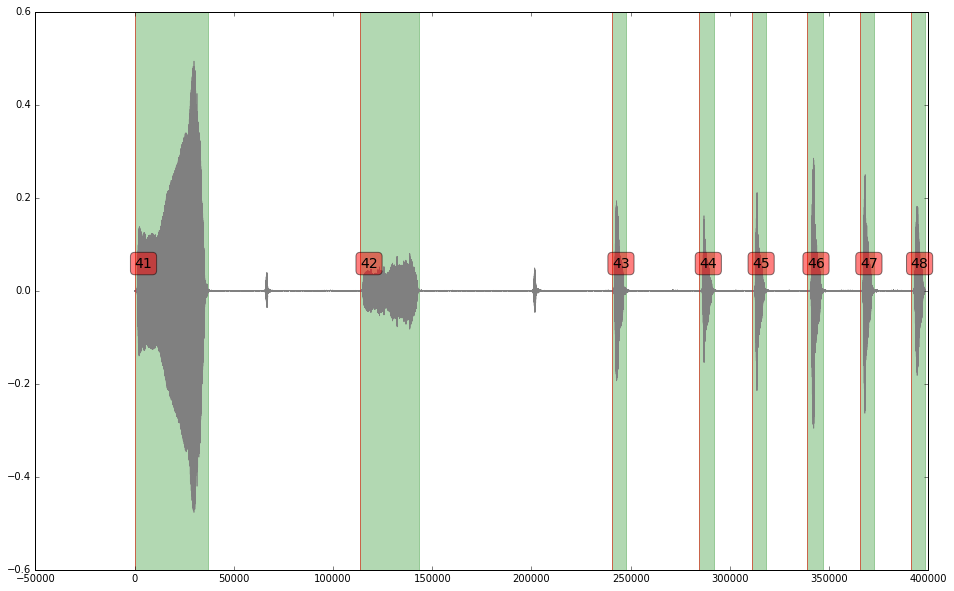

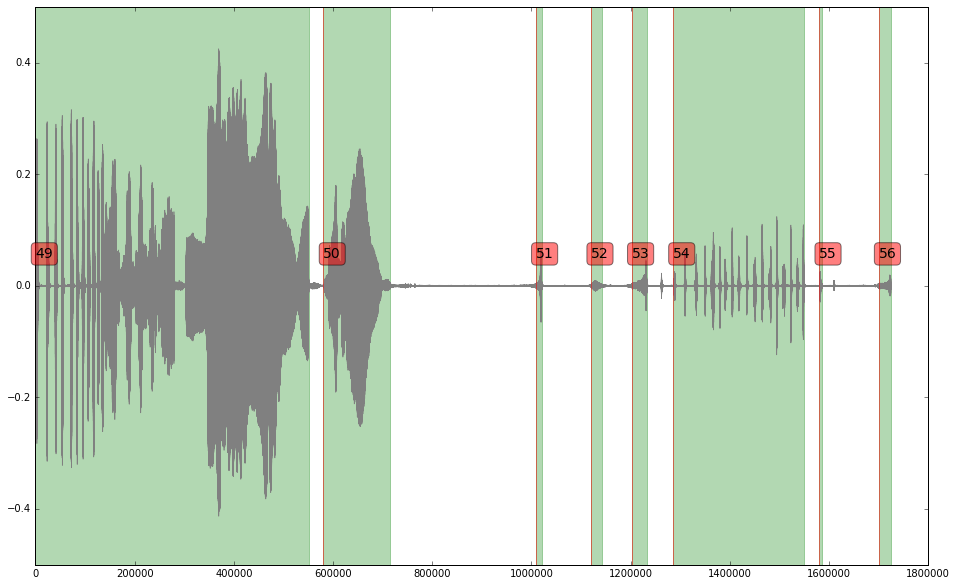

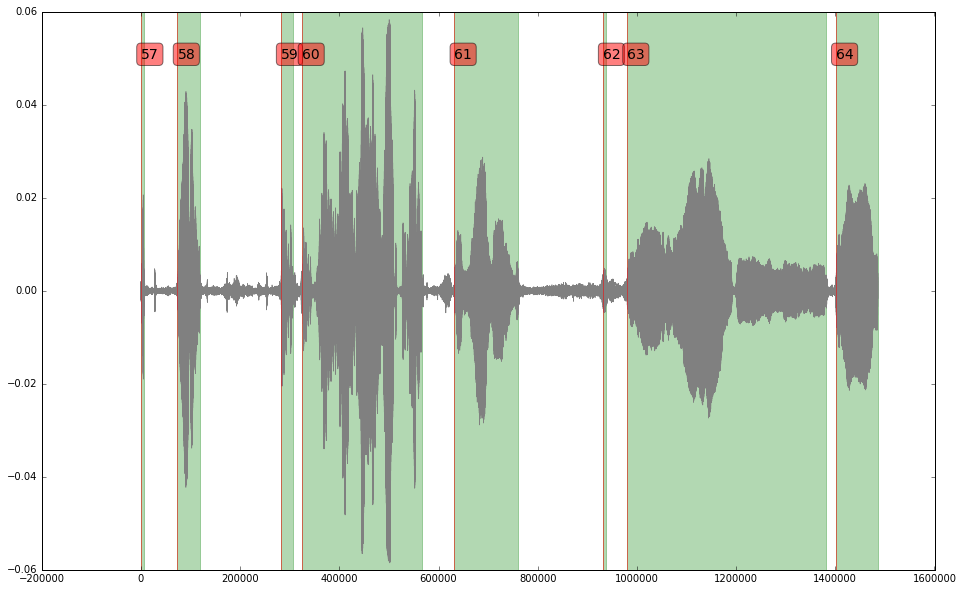

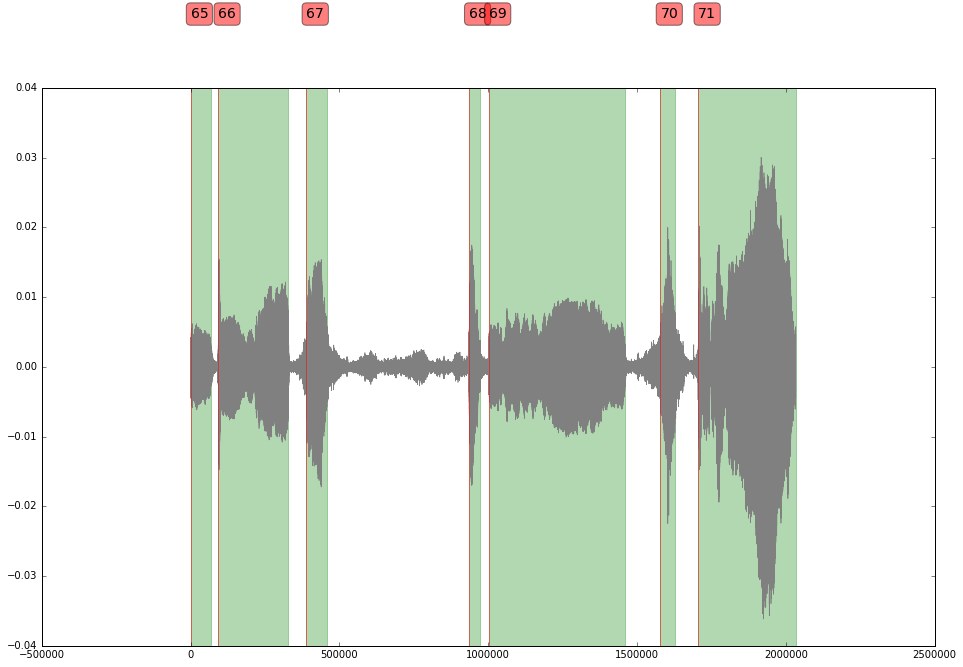

In [12]:
groups = groupBySilence(audio2,minGapSize=minGapSize,t_silence=t_silence,orderDivisor=15)
plotGroups(audio2,groups)

###### Example 2: Preprocessed groups of snaredrum recording

0.01
8
46


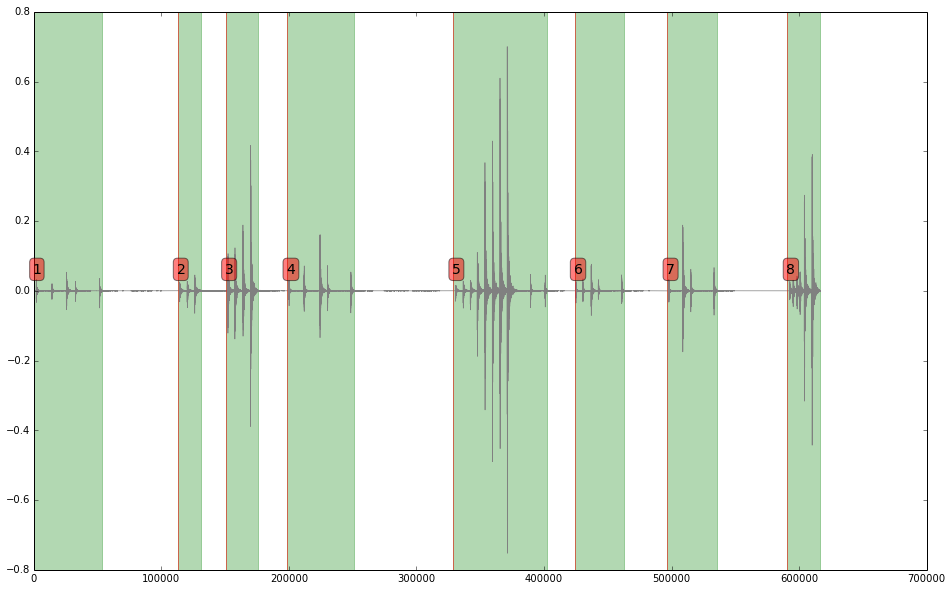

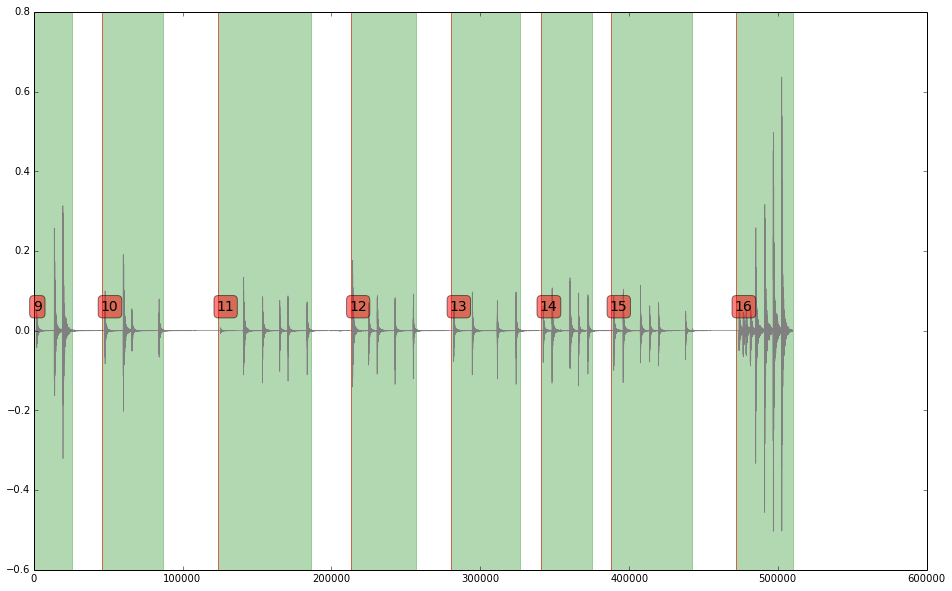

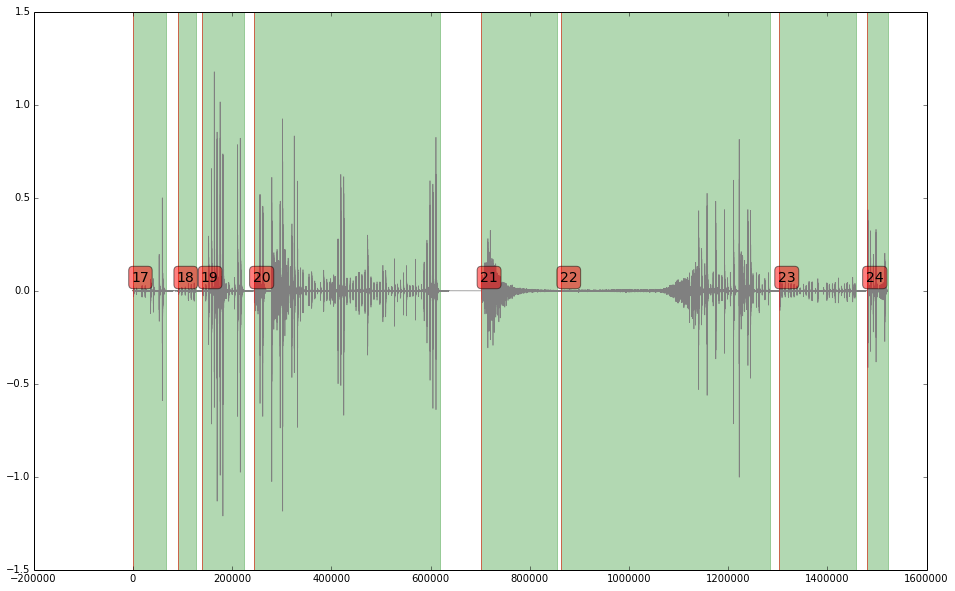

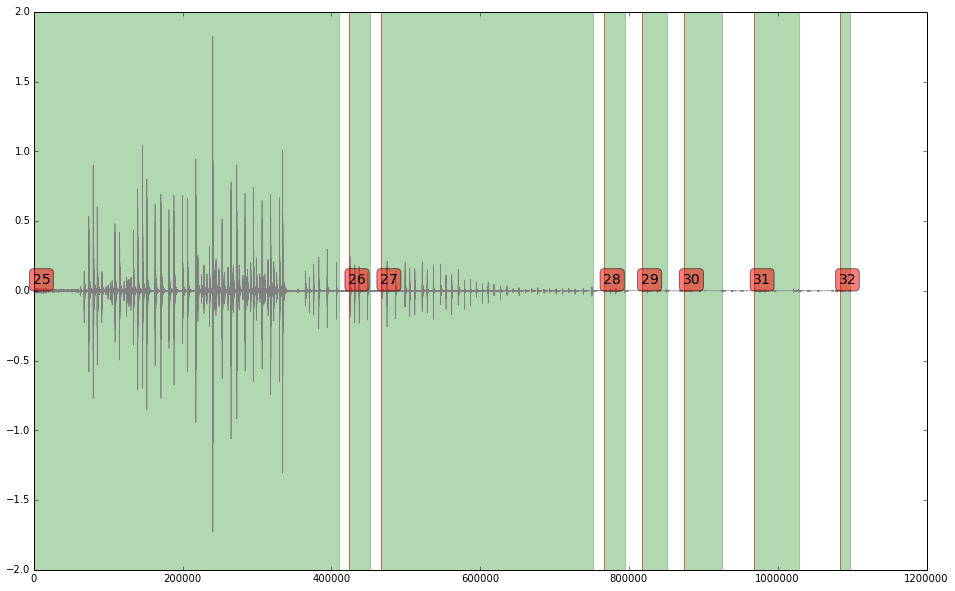

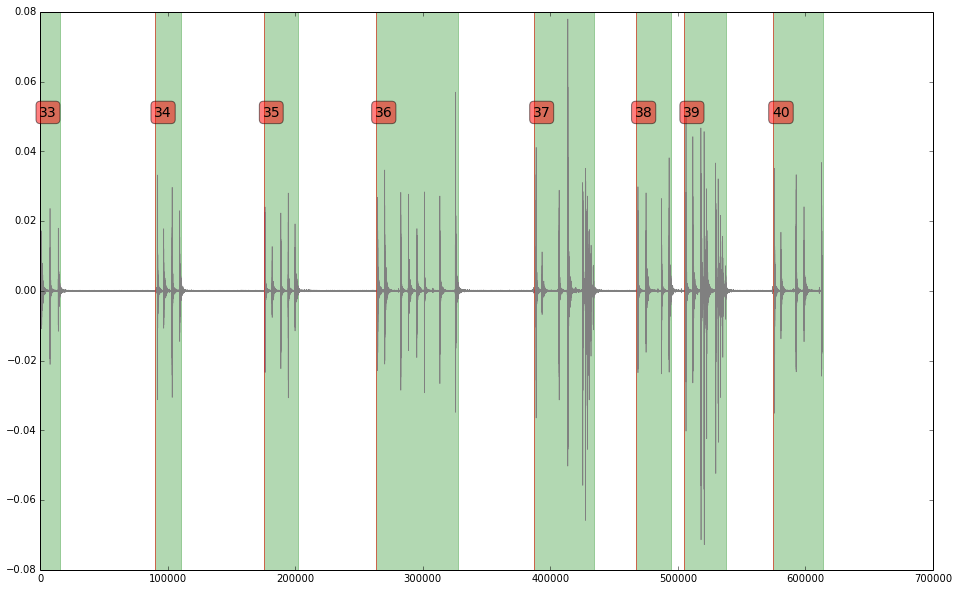

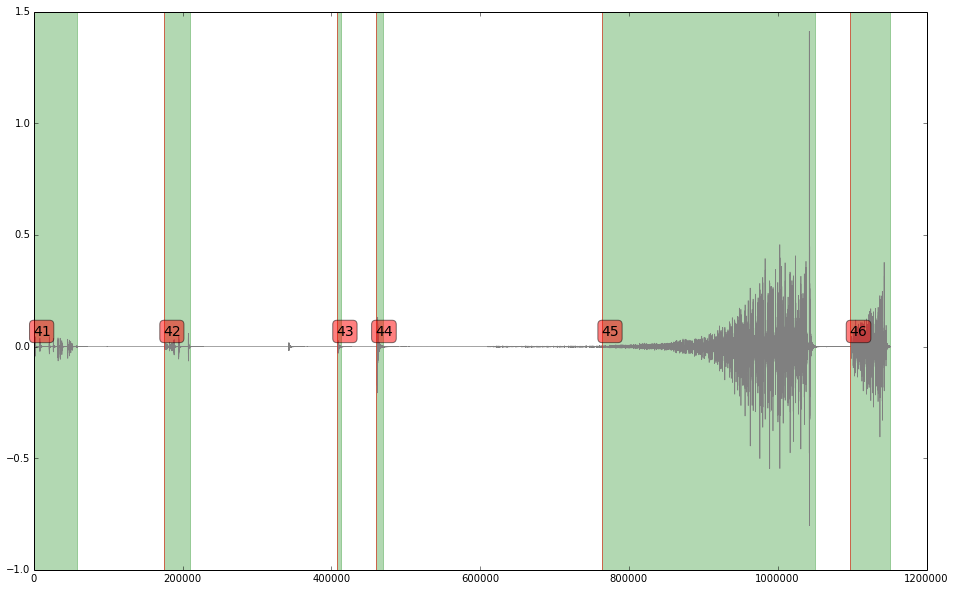

In [64]:
t_silence = track[6]
print t_silence

minGapSize = track[7]
print minGapSize

groups = groupBySilence(audio,minGapSize=minGapSize,t_silence=t_silence)
print len(groups)

plotGroups(audio,groups)

### <br> <br> <hr> <br> <br> <hr> <br> <br> <hr> <i>not integrated:</i> <br>Combine small groups

In [ ]:
preprocessedGroups = groupBySilence(audio2[35*samplerate:60*samplerate])

In [ ]:
def combineGroups(groups,t_min=2.0,plot=0):
    deleteList = []
    combinedGroups = []
    for i in range(0,len(groups)):
        length = (groups[i][1]-groups[i][0])/samplerate
        
        gapBefore = 1000000
        gapAfter = 1000000
        
        if i>0:
            gapBefore = (groups[i][0]-groups[i-1][1])/samplerate
            
        if i<len(groups)-1:
            gapAfter = (groups[i+1][0]-groups[i][1])/samplerate            
        
        if length < t_min:
            #print "%f, %f, %f" % (length,gapBefore,gapAfter)
            if gapBefore < gapAfter:
                groups[i-1][1] = groups[i][1]
            else:
                groups[i+1][0] = groups[i][0]
        
            deleteList.append(i)

    for i in range(0,len(groups)):
        if i not in deleteList:
            combinedGroups.append(groups[i])
            
    return groups

### <br> <br> <hr> <i>not integrated:</i> <br> Subdevide by changes in continuous feature data

In [ ]:
from scipy.signal import argrelmax       
from essentia.standard import *

def groupByFeatures(audio,hopSize=4*1024,plot=0):
    timestamps = len(audio)
    
    energy = Energy()
    effectiveDuration = essentia.standard.EffectiveDuration(sampleRate=samplerate,thresholdRatio=0.01)
    loudness = essentia.standard.Loudness()
    zerocrossingrate = essentia.standard.ZeroCrossingRate()
    w = essentia.standard.Windowing()
    spec = essentia.standard.Spectrum()
    centroid = essentia.standard.Centroid()
    SpectralComplexity = essentia.standard.SpectralComplexity(sampleRate=samplerate)
    SpectralRolloff = essentia.standard.RollOff(sampleRate=samplerate)
    SpectralFlux = essentia.standard.Flux()
    Envelope = essentia.standard.Envelope()
    TCToTotal = essentia.standard.TCToTotal()
    LAT = essentia.standard.LogAttackTime()
    Pitch = essentia.standard.PitchYinFFT(sampleRate=samplerate)
    SpectralPeaks = essentia.standard.SpectralPeaks(sampleRate=samplerate)
    Dissonance = essentia.standard.Dissonance()
    
    featurelist = ["Energy","Loudness","ZCR","SpectralCentroid","SpectralComplexity","SpectralRolloff","SpectralFlux","Pitch","Roughness"]
    features = {}

    for feature in featurelist:
        features[feature] = {}
        features[feature]["raw"]=[]

    for frame in FrameGenerator(audio, frameSize = hopSize*2, hopSize = hopSize):

        features["dynamicBalance"]=TCToTotal(Envelope(frame))
        features["LogAttackTime"]=LAT(Envelope(frame))            
        features["Loudness"]["raw"].append(loudness(frame))
        features["Energy"]["raw"].append(energy(frame)) 
        features["ZCR"]["raw"].append(zerocrossingrate(frame))
        spectrum = spec(w(frame))
        features["SpectralCentroid"]["raw"].append(centroid(spectrum))
        features["SpectralComplexity"]["raw"].append(SpectralComplexity(spectrum))
        features["SpectralRolloff"]["raw"].append(SpectralRolloff(spectrum))
        features["SpectralFlux"]["raw"].append(SpectralFlux(spectrum))
        peaks = SpectralPeaks(spectrum)
        features["Roughness"]["raw"].append(Dissonance(peaks[0],peaks[1]))

        (pitch,pitchConfidence) = Pitch(spectrum)
        if (pitchConfidence>0.5):
            features["Pitch"]["raw"].append(pitch)
        else:
            features["Pitch"]["raw"].append(0.0)
    
    feature_x = range(0,timestamps-1,hopSize)
    
    featureRaw = []

    for feature in featurelist:
        
        feature_y = features[feature]["raw"][0:len(feature_x)]
        dif = abs(diff(feature_y))
        features[feature]["diff"] = abs(diff(dif))
        
        #featureArray = np.asarray(features[feature]["diff"])
        #maxima = argrelmax(featureArray, order=10)
        #features[feature]["maxima"] = maxima[0]
        
        diffArray = np.asarray(features[feature]["diff"])
        normalizedArray = diffArray/norm(diffArray)
        featureRaw.append(normalizedArray)
        
    
    featureSum = np.sum(featureRaw, axis=0)
    featureArray = np.asarray(features["Energy"]["diff"])
    maxima = argrelmax(featureArray, order=10)
    featureMaxima = maxima[0]
    
    print featureMaxima
    
    for boundary in featureMaxima:
        
        if (boundary > 0) &  (boundary * hopSize < len(audio)):
            frame = audio[(boundary*hopSize)-hopSize:(boundary*hopSize)+hopSize]
            #print loudness(frame)
    
    
    
    groups = []
    
    #for edge in featureMaxima:
    #    groups.append([edge[0]])
    #print featureMaxima
    
    if 0:
        plt.figure(figsize=(16, 10))
        plt.plot(audio,'0.5',label="Audio Waveform",linewidth=0.7)
        #ax2 = plt.twinx()
        #ax2.plot(feature_x[0:len(featureSum)],featureSum,color='g',linewidth=1.1)

        colors = cm.rainbow(np.linspace(0, 1, len(featurelist)))
        colorindex = 0
        featurecolor={}
        ax = {}

        for feature in featurelist:
            featurecolor[feature] = colors[colorindex]
            #ax[feature]=plt.twinx()
            #ax[feature].plot(feature_x[0:len(features[feature]["diff"])],features[feature]["diff"],color=featurecolor[feature],linewidth=0.5) 
            colorindex+=1
            #for edge in features[feature]["maxima"]:
               #plt.axvline(x=edge*hopSize,linewidth=0.7,color=featurecolor[feature])

        for edge in featureMaxima:
            plt.axvline(x=edge*hopSize,linewidth=2,color='g')
        
        
        wavPlayer(audio,samplerate)
        plt.show()

In [ ]:
groups = groupBySilence(audio2,t_silence=0.01)
length = 0
print "total length: %f s" % (groups[-1][1]/samplerate)
for group in groups:
    length += ((group[1]-group[0])/samplerate)
    print "%f" % ((group[1]-group[0])/samplerate)
    groupByFeatures(audio2[group[0]:group[1]],plot=1)
    print "----"
print length